# An Introduction to Football Analytics: How to make an average position map for Football Data Analysis using Python

In [ ]:
!pip install mplsoccer
!pip install statsbombpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsbombpy import sb
from mplsoccer import Pitch, VerticalPitch

In [ ]:
sb.competitions()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2022-12-01T11:42:34.874323,2021-06-13T16:17:31.694,None,2022-12-01T11:42:34.874323
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
3,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,26,Europe,Champions League,male,False,False,2014/2015,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
5,16,25,Europe,Champions League,male,False,False,2013/2014,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
6,16,24,Europe,Champions League,male,False,False,2012/2013,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-07-10T13:41:45.751
7,16,23,Europe,Champions League,male,False,False,2011/2012,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
8,16,22,Europe,Champions League,male,False,False,2010/2011,2022-01-26T21:07:11.033473,2021-06-13T16:17:31.694,None,2022-01-26T21:07:11.033473
9,16,21,Europe,Champions League,male,False,False,2009/2010,2022-11-15T17:26:10.871011,2021-06-13T16:17:31.694,None,2022-11-15T17:26:10.871011


In [ ]:
matches = sb.matches(competition_id=16, season_id=23)
matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,18237,2012-05-19,20:45:00.000,Europe - Champions League,2011/2012,Bayern Munich,Chelsea,1,1,available,...,2021-06-13T16:17:31.694,1,Final,Allianz Arena,Pedro Proença,Josef Heynckes,Roberto Di Matteo,1.0.3,None,None


In [ ]:
events = sb.events(18237)

In [ ]:
# Split existing location columns into x and y (and z if appropriate) components

# location
events[['location_x', 'location_y']] = events['location'].apply(pd.Series)

# pass destination location
events[['pass_end_location_x', 'pass_end_location_y']] = events['pass_end_location'].apply(pd.Series)

# shot destination location
events[['shot_end_location_x', 'shot_end_location_y', 'shot_end_location_z']] = events['shot_end_location'].apply(pd.Series)

In [ ]:
events_df = events[[
    'index', 'id', 'duration', 'minute', 'pass_outcome',
    'pass_recipient', 'period', 'play_pattern', 'player',
    'player_id', 'position', 'possession', 'possession_team', 'team', 'timestamp',
    'type', 'location_x', 'location_y', 'pass_end_location_x',
    'pass_end_location_y'
]]

In [ ]:
# list of values in type column
event_type = set(events_df['type'].tolist())
print(event_type)

{'Interception', 'Miscontrol', 'Clearance', 'Foul Won', 'Bad Behaviour', 'Foul Committed', 'Half End', 'Pass', 'Tactical Shift', 'Half Start', 'Dribble', 'Pressure', 'Shot', 'Dribbled Past', 'Injury Stoppage', 'Ball Receipt*', 'Dispossessed', 'Carry', 'Ball Recovery', 'Shield', 'Block', 'Goal Keeper', 'Substitution', 'Player Off', 'Offside', 'Duel', 'Player On', 'Starting XI'}


## Chelsea FC Average Position

In [ ]:
# Chelsea squad
chelsea_lineup = sb.lineups(match_id=18237)["Chelsea"]

# Chelsea players who played at any point in the match
chelsea_played = chelsea_lineup[chelsea_lineup.positions.str.len()>0]

# Chelsea players who started the match
chelsea_started_list = []
for index, row in chelsea_played.iterrows():
  if row['positions'][0]['from'] == '00:00':
    chelsea_started_list.append(row['player_id'])

chelsea_started = chelsea_played[chelsea_played['player_id'].isin(chelsea_started_list)]
chelsea_started

,player_id,player_name,player_nickname,jersey_number,country,cards,positions
1,3294,Juan Manuel Mata García,Juan Mata,10,Spain,[],"[{'position_id': 19, 'position': 'Center Attac..."
2,3461,Petr Čech,None,1,Czech Republic,[],"[{'position_id': 1, 'position': 'Goalkeeper', ..."
4,3645,Gary Cahill,None,24,England,[],"[{'position_id': 5, 'position': 'Left Center B..."
5,3956,David Luiz Moreira Marinho,David Luiz,4,Brazil,"[{'time': '85:05', 'card_type': 'Yellow Card',...","[{'position_id': 3, 'position': 'Right Center ..."
6,5475,John Michael Nchekwube Obinna,John Obi Mikel,12,Nigeria,[],"[{'position_id': 9, 'position': 'Right Defensi..."
8,8575,Salomon Armand Magloire Kalou,Salomon Kalou,21,Côte d'Ivoire,[],"[{'position_id': 17, 'position': 'Right Wing',..."
9,12529,Ashley Cole,None,3,England,"[{'time': '80:49', 'card_type': 'Yellow Card',...","[{'position_id': 6, 'position': 'Left Back', '..."
11,20018,José Bosingwa da Silva,José Bosingwa,17,Portugal,[],"[{'position_id': 2, 'position': 'Right Back', ..."
12,20045,Ryan Bertrand,None,34,England,[],"[{'position_id': 21, 'position': 'Left Wing', ..."
14,20330,Frank Lampard,None,8,England,[],"[{'position_id': 11, 'position': 'Left Defensi..."


In [ ]:
Juan = events_df.loc[events_df['player'] == 'Juan Manuel Mata García']
Juan_pos = Juan[['location_x', 'location_y']]

average_x = []
average_y = []

for index, row in Juan_pos.iterrows():
  average_x.append(row['location_x'])
  average_y.append(row['location_y'])

average_x = sum(average_x) / len(average_x)
average_y = sum(average_y) / len(average_y)

print(average_x) # vertical position
print(average_y) # horizontal position

67.47410358565737
45.69322709163347


In [ ]:
for index, row in chelsea_started.iterrows():

  player_name = row['player_name']
  player_df = events_df.loc[events_df['player'] == player_name]

  average_x = []
  average_y = []

  for index, row in player_df.iterrows():
    if str(row['location_x']) != 'nan':
      if str(row['location_y']) != 'nan':
        average_x.append(row['location_x'])
        average_y.append(row['location_y'])

  average_x = sum(average_x) / len(average_x)
  average_y = sum(average_y) / len(average_y)

  print(player_name, average_x, average_y)

Juan Manuel Mata García 67.47410358565737 45.69322709163347
Petr Čech 8.48407643312102 38.859872611464965
Gary Cahill 38.89261744966443 53.147651006711406
David Luiz Moreira Marinho 36.48344370860927 25.278145695364238
John Michael Nchekwube Obinna 48.829268292682926 45.08130081300813
Salomon Armand Magloire Kalou 65.97222222222223 57.84722222222222
Ashley Cole 48.94915254237288 14.649717514124294
José Bosingwa da Silva 50.65895953757225 68.5606936416185
Ryan Bertrand 64.10576923076923 13.89423076923077
Frank Lampard 52.67169811320755 35.8
Didier Yves Drogba Tébily 77.39378238341969 33.52849740932643


In [ ]:
import matplotlib.font_manager as font_manager

my_font = 'ComingSoon-Regular.ttf'

font_name = font_manager.FontProperties(fname=my_font, size= 20)
font_number = font_manager.FontProperties(fname=my_font, size= 30)
font_title = font_manager.FontProperties(fname=my_font, size= 60, weight='bold')
font_score = font_manager.FontProperties(fname=my_font, size= 32, weight='bold')

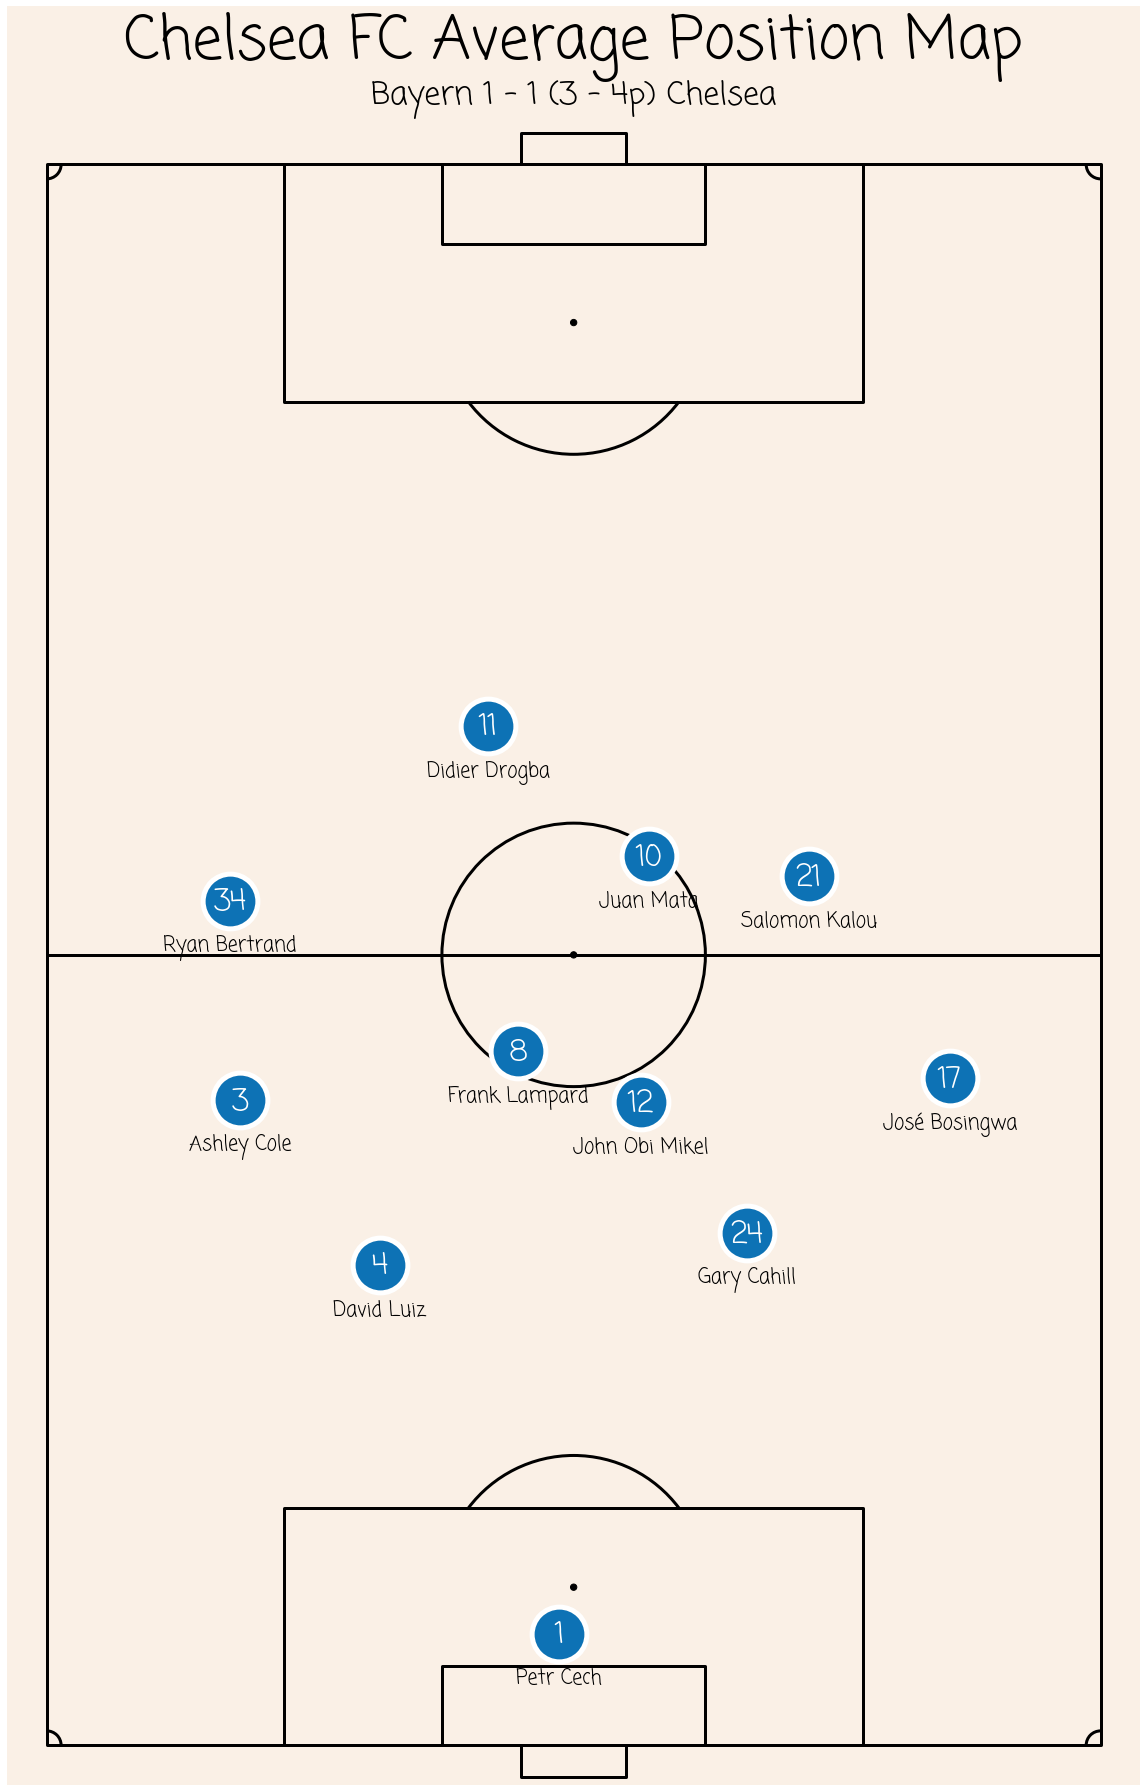

In [ ]:
# Define colours
pitch_colour = '#FAF0E6'
line_colour = 'black'
goal_colour = 'darkgreen'
shot_on_colour = 'green'
shot_off_colour = 'darkred'
shot_block_colour = 'grey'
text_colour = 'black'

node_size = 3000
node_colour = '#0D72B5'
edge_colour= 'white'


# Draw the pitch
pitch = VerticalPitch(corner_arcs=True, goal_type='box',
                      pad_bottom=3, pad_top=12, pad_left=3, pad_right=3,
                      pitch_color=pitch_colour, line_color=line_colour, linewidth=3)
fig, ax = pitch.draw(figsize=(25, 25))

# Add title text
pitch.annotate('Chelsea FC Average Position Map', xy=(129, 40), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_title)
pitch.annotate('Bayern 1 - 1 (3 - 4p) Chelsea', xy=(125, 40), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_score)

for index, row in chelsea_started.iterrows():

  if str(row["player_name"]) == 'Petr Čech':
    display_name = 'Petr Cech'
  elif str(row["player_nickname"]) == 'None':
    display_name = row['player_name']
  else:
    display_name = row['player_nickname']

  shirt_number = row['jersey_number']
  player_name = row['player_name']
  player_df = events_df.loc[events_df['player'] == player_name]

  average_x = []
  average_y = []

  for index, row in player_df.iterrows():
    if str(row['location_x']) != 'nan':
      if str(row['location_y']) != 'nan':
        average_x.append(row['location_x'])
        average_y.append(row['location_y'])

  average_x = sum(average_x) / len(average_x)
  average_y = sum(average_y) / len(average_y)


  player_node = pitch.scatter(average_x, average_y, s=node_size, color=node_colour, edgecolors=edge_colour, linewidth=5, alpha=1, ax=ax)
  pitch.annotate(display_name, xy=(average_x - 3.5, average_y), c=text_colour, va='center', ha='center', ax=ax, font_properties=font_name)
  pitch.annotate(shirt_number, xy=(average_x - 0.25, average_y), c='white', va='center', ha='center', ax=ax, font_properties=font_number)

## FC Bayern Munich Average Position

In [ ]:
# Bayern Munich squad
bayern_munich_lineup = sb.lineups(match_id=18237)["Bayern Munich"]

# bayern Munich players who played at any point in the match
bayern_munich_played = bayern_munich_lineup[bayern_munich_lineup.positions.str.len()>0]

# Bayern Munich players who started the match
bayern_munich_started_list = []
for index, row in bayern_munich_played.iterrows():
  if row['positions'][0]['from'] == '00:00':
   bayern_munich_started_list.append(row['player_id'])

bayern_munich_started = bayern_munich_played[bayern_munich_played['player_id'].isin(bayern_munich_started_list)]
bayern_munich_played

,player_id,player_name,player_nickname,jersey_number,country,cards,positions
0,4628,Diego Armando Valentin Contento,Diego Contento,26,Germany,[],"[{'position_id': 6, 'position': 'Left Back', '..."
1,5562,Thomas Müller,None,25,Germany,[],"[{'position_id': 19, 'position': 'Center Attac..."
2,5565,Mario Gómez García,Mario Gómez,33,Germany,[],"[{'position_id': 23, 'position': 'Center Forwa..."
3,5570,Manuel Neuer,None,1,Germany,[],"[{'position_id': 1, 'position': 'Goalkeeper', ..."
4,5574,Toni Kroos,None,39,Germany,[],"[{'position_id': 11, 'position': 'Left Defensi..."
5,5578,Jérôme Boateng,None,17,Germany,[],"[{'position_id': 3, 'position': 'Right Center ..."
8,8218,Arjen Robben,None,10,Netherlands,[],"[{'position_id': 17, 'position': 'Right Wing',..."
9,8223,Franck Bilal Ribéry,Franck Ribéry,7,France,[],"[{'position_id': 21, 'position': 'Left Wing', ..."
11,13014,Anatoliy Tymoshchuk,None,44,Ukraine,[],"[{'position_id': 5, 'position': 'Left Center B..."
12,18414,Bastian Schweinsteiger,None,31,Germany,"[{'time': '01:44', 'card_type': 'Yellow Card',...","[{'position_id': 9, 'position': 'Right Defensi..."


In [ ]:
for index, row in bayern_munich_started.iterrows():

  player_name = row['player_name']
  player_df = events_df.loc[events_df['player'] == player_name]

  average_x = []
  average_y = []

  for index, row in player_df.iterrows():
    if str(row['location_x']) != 'nan':
      if str(row['location_y']) != 'nan':
        average_x.append(row['location_x'])
        average_y.append(row['location_y'])

  average_x = sum(average_x) / len(average_x)
  average_y = sum(average_y) / len(average_y)

  print(player_name, average_x, average_y)

Diego Armando Valentin Contento 61.388888888888886 15.416666666666666
Thomas Müller 88.3546511627907 50.354651162790695
Mario Gómez García 86.08181818181818 44.163636363636364
Manuel Neuer 9.973333333333333 43.0
Toni Kroos 66.68529411764706 33.20882352941177
Jérôme Boateng 43.44 30.54
Arjen Robben 86.61764705882354 57.99346405228758
Franck Bilal Ribéry 81.98373983739837 22.98780487804878
Anatoliy Tymoshchuk 51.447257383966246 54.16877637130802
Bastian Schweinsteiger 62.10963455149502 35.98006644518272
Philipp Lahm 66.80985915492958 66.26408450704226


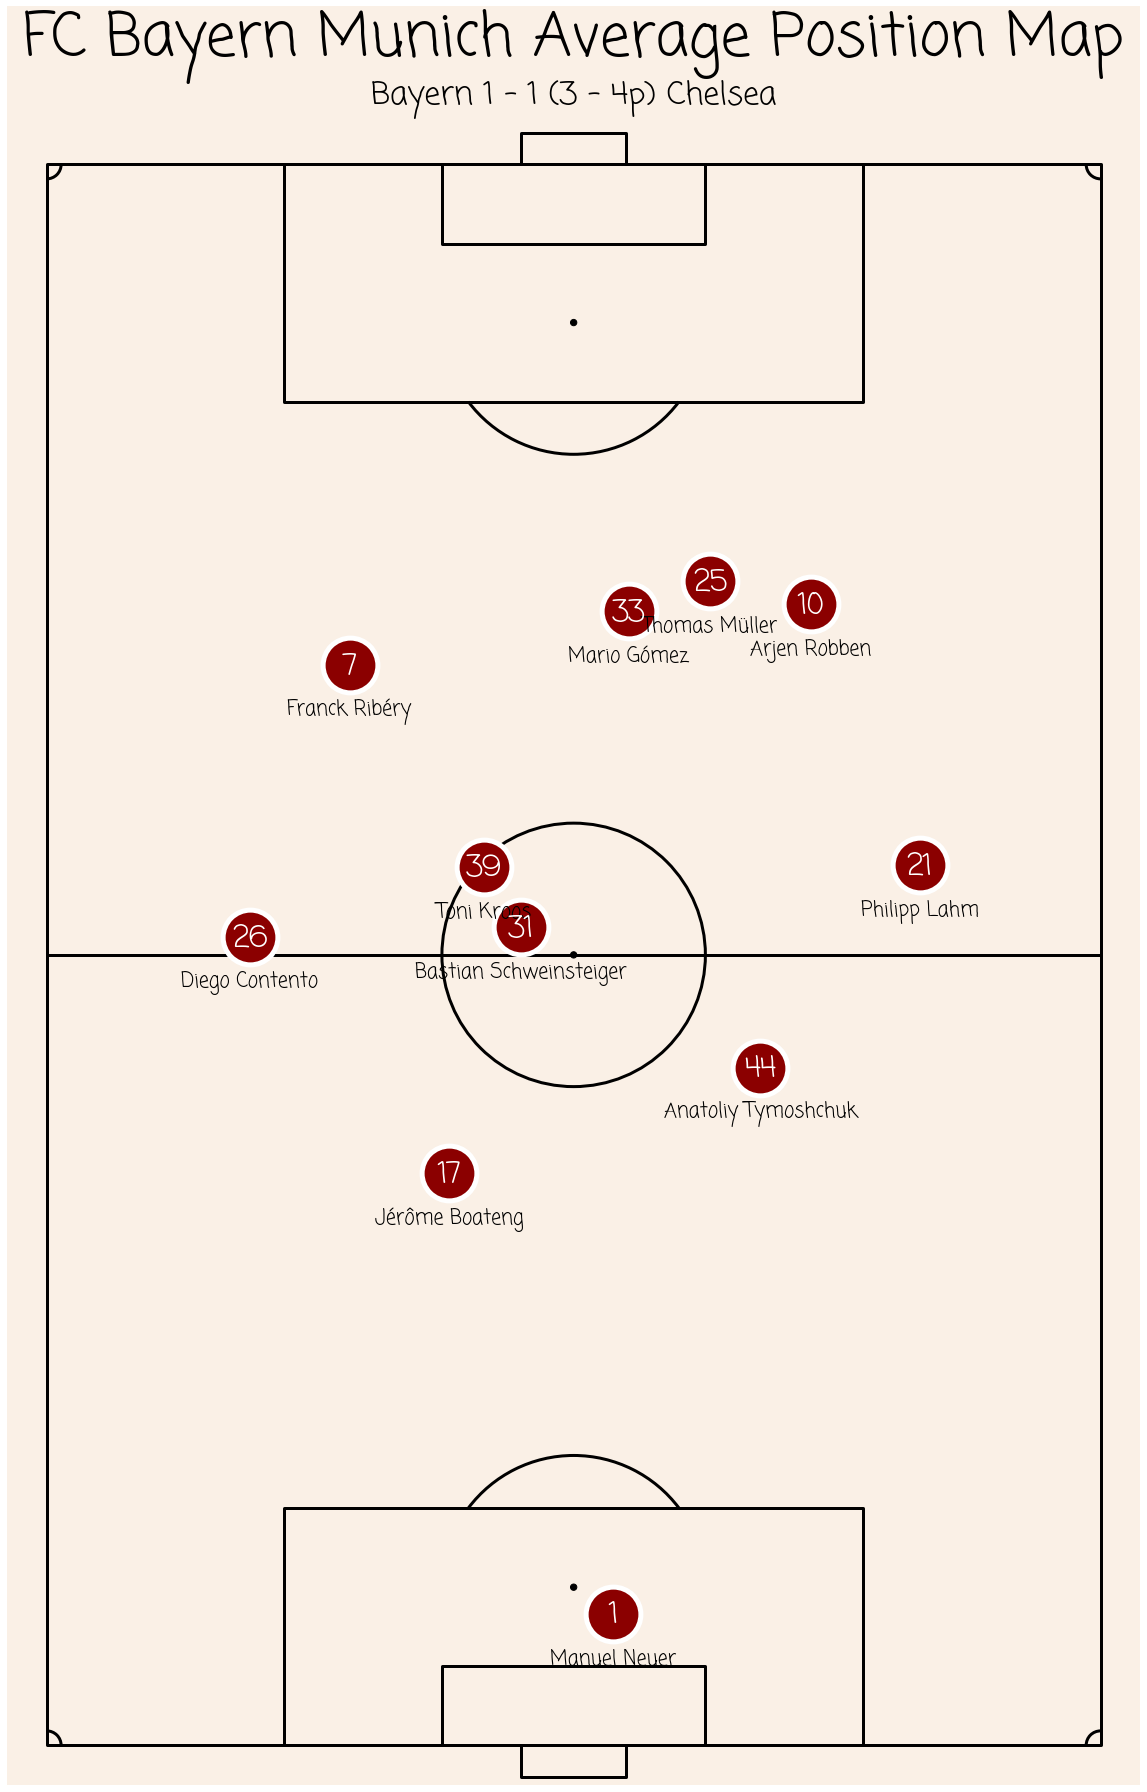

In [ ]:
# Define colours
pitch_colour = '#FAF0E6'
line_colour = 'black'
goal_colour = 'darkgreen'
shot_on_colour = 'green'
shot_off_colour = 'darkred'
shot_block_colour = 'grey'
text_colour = 'black'

node_size = 3000
node_colour = 'darkred'
edge_colour= 'white'


# Draw the pitch
pitch = VerticalPitch(corner_arcs=True, goal_type='box',
                      pad_bottom=3, pad_top=12, pad_left=3, pad_right=3,
                      pitch_color=pitch_colour, line_color=line_colour, linewidth=3)
fig, ax = pitch.draw(figsize=(25, 25))

# Add title text
pitch.annotate('FC Bayern Munich Average Position Map', xy=(129, 40), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_title)
pitch.annotate('Bayern 1 - 1 (3 - 4p) Chelsea', xy=(125, 40), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_score)

for index, row in bayern_munich_started.iterrows():

  if str(row["player_name"]) == 'Ivica Olić':
    display_name = 'Ivica Olic'
  elif str(row["player_nickname"]) == 'None':
    display_name = row['player_name']
  else:
    display_name = row['player_nickname']

  shirt_number = row['jersey_number']
  player_name = row['player_name']
  player_df = events_df.loc[events_df['player'] == player_name]

  average_x = []
  average_y = []

  for index, row in player_df.iterrows():
    if str(row['location_x']) != 'nan':
      if str(row['location_y']) != 'nan':
        average_x.append(row['location_x'])
        average_y.append(row['location_y'])

  average_x = sum(average_x) / len(average_x)
  average_y = sum(average_y) / len(average_y)


  player_node = pitch.scatter(average_x, average_y, s=node_size, color=node_colour, edgecolors=edge_colour, linewidth=5, alpha=1, ax=ax)
  pitch.annotate(display_name, xy=(average_x - 3.5, average_y), c=text_colour, va='center', ha='center', ax=ax, font_properties=font_name)
  pitch.annotate(shirt_number, xy=(average_x - 0.25, average_y), c='white', va='center', ha='center', ax=ax, font_properties=font_number)

## Combined Average Position Map

In [ ]:
combined_started = chelsea_started.append(bayern_munich_started)

combined_played = chelsea_played.append(bayern_munich_played)
combined_played

,player_id,player_name,player_nickname,jersey_number,country,cards,positions
1,3294,Juan Manuel Mata García,Juan Mata,10,Spain,[],"[{'position_id': 19, 'position': 'Center Attac..."
2,3461,Petr Čech,None,1,Czech Republic,[],"[{'position_id': 1, 'position': 'Goalkeeper', ..."
4,3645,Gary Cahill,None,24,England,[],"[{'position_id': 5, 'position': 'Left Center B..."
5,3956,David Luiz Moreira Marinho,David Luiz,4,Brazil,"[{'time': '85:05', 'card_type': 'Yellow Card',...","[{'position_id': 3, 'position': 'Right Center ..."
6,5475,John Michael Nchekwube Obinna,John Obi Mikel,12,Nigeria,[],"[{'position_id': 9, 'position': 'Right Defensi..."
7,6382,Fernando José Torres Sanz,Fernando Torres,9,Spain,"[{'time': '11:58', 'card_type': 'Yellow Card',...","[{'position_id': 17, 'position': 'Right Wing',..."
8,8575,Salomon Armand Magloire Kalou,Salomon Kalou,21,Côte d'Ivoire,[],"[{'position_id': 17, 'position': 'Right Wing',..."
9,12529,Ashley Cole,None,3,England,"[{'time': '80:49', 'card_type': 'Yellow Card',...","[{'position_id': 6, 'position': 'Left Back', '..."
11,20018,José Bosingwa da Silva,José Bosingwa,17,Portugal,[],"[{'position_id': 2, 'position': 'Right Back', ..."
12,20045,Ryan Bertrand,None,34,England,[],"[{'position_id': 21, 'position': 'Left Wing', ..."


### Combined Average Position Map (Vertical Pitch)

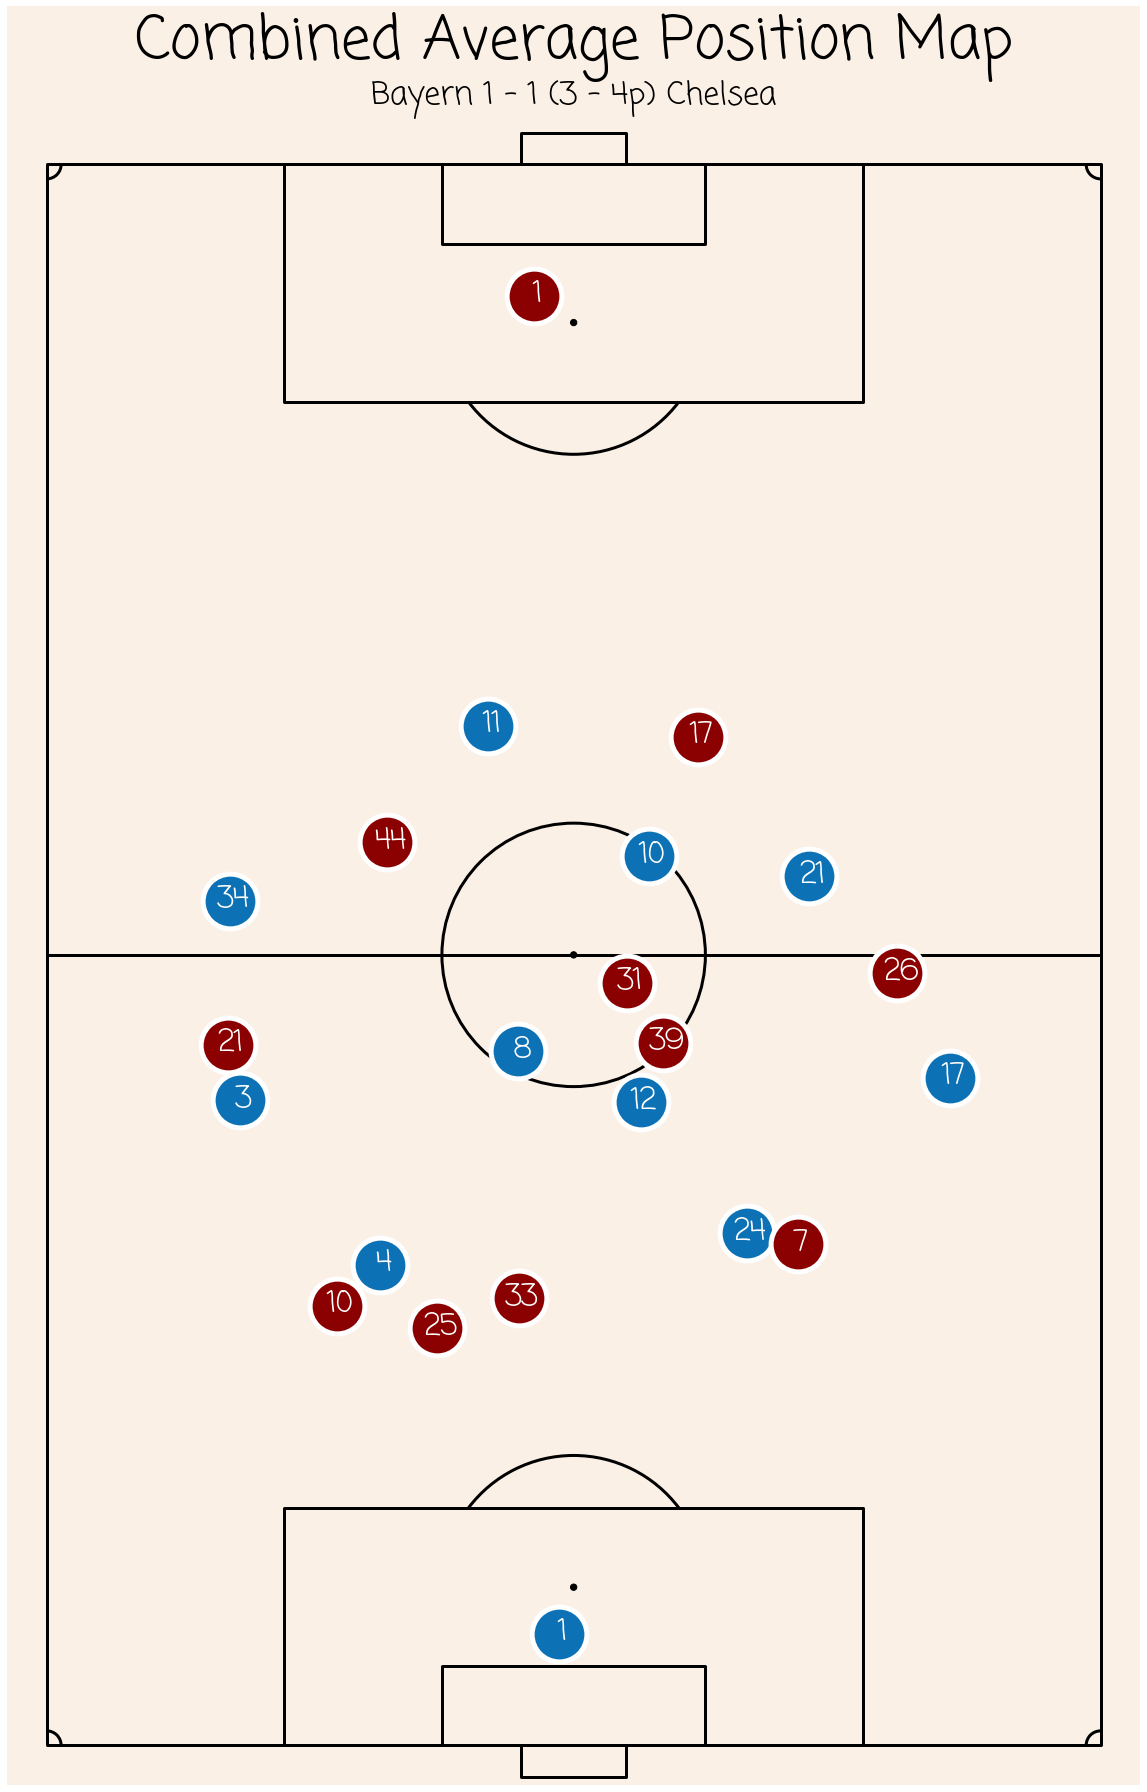

In [ ]:
# Define colours
pitch_colour = '#FAF0E6'
line_colour = 'black'
goal_colour = 'darkgreen'
shot_on_colour = 'green'
shot_off_colour = 'darkred'
shot_block_colour = 'grey'
text_colour = 'black'

node_size = 3000
bayern_munich_node_colour = 'darkred'
chelsea_node_colour = '#0D72B5'
edge_colour= 'white'


# Draw the pitch
pitch = VerticalPitch(corner_arcs=True, goal_type='box',
                      pad_bottom=3, pad_top=12, pad_left=3, pad_right=3,
                      pitch_color=pitch_colour, line_color=line_colour, linewidth=3)
fig, ax = pitch.draw(figsize=(25, 25))


# Add title text
pitch.annotate('Combined Average Position Map', xy=(129, 40), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_title)
pitch.annotate('Bayern 1 - 1 (3 - 4p) Chelsea', xy=(125, 40), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_score)

for index, row in combined_started.iterrows():

  if str(row["player_name"]) == 'Petr Čech':
    display_name = 'Petr Cech'
  elif str(row["player_name"]) == 'Ivica Olić':
    display_name = 'Ivica Olic'
  elif str(row["player_nickname"]) == 'None':
    display_name = row['player_name']
  else:
    display_name = row['player_nickname']

  shirt_number = row['jersey_number']
  player_name = row['player_name']
  player_df = events_df.loc[events_df['player'] == player_name]

  average_x = []
  average_y = []

  for index, row in player_df.iterrows():

    team = row['team']

    if str(row['location_x']) != 'nan':
      if str(row['location_y']) != 'nan':

        if team == 'Chelsea':
          node_colour = chelsea_node_colour

          average_x.append(row['location_x'])
          average_y.append(row['location_y'])

        else:
          node_colour = bayern_munich_node_colour

          average_x.append(120 - row['location_x'])
          average_y.append(80 - row['location_y'])

  average_x = sum(average_x) / len(average_x)
  average_y = sum(average_y) / len(average_y)

  player_node = pitch.scatter(average_x, average_y, s=node_size, color=node_colour, edgecolors=edge_colour, linewidth=5, alpha=1, ax=ax)
  # pitch.annotate(display_name, xy=(average_x, average_y + 3.5), c=text_colour, va='center', ha='center', ax=ax, font_properties=font_name)
  pitch.annotate(shirt_number, xy=(average_x, average_y + 0.25), c='white', va='center', ha='center', ax=ax, font_properties=font_number)

### Combined Average Position Map (Horizontal Pitch)

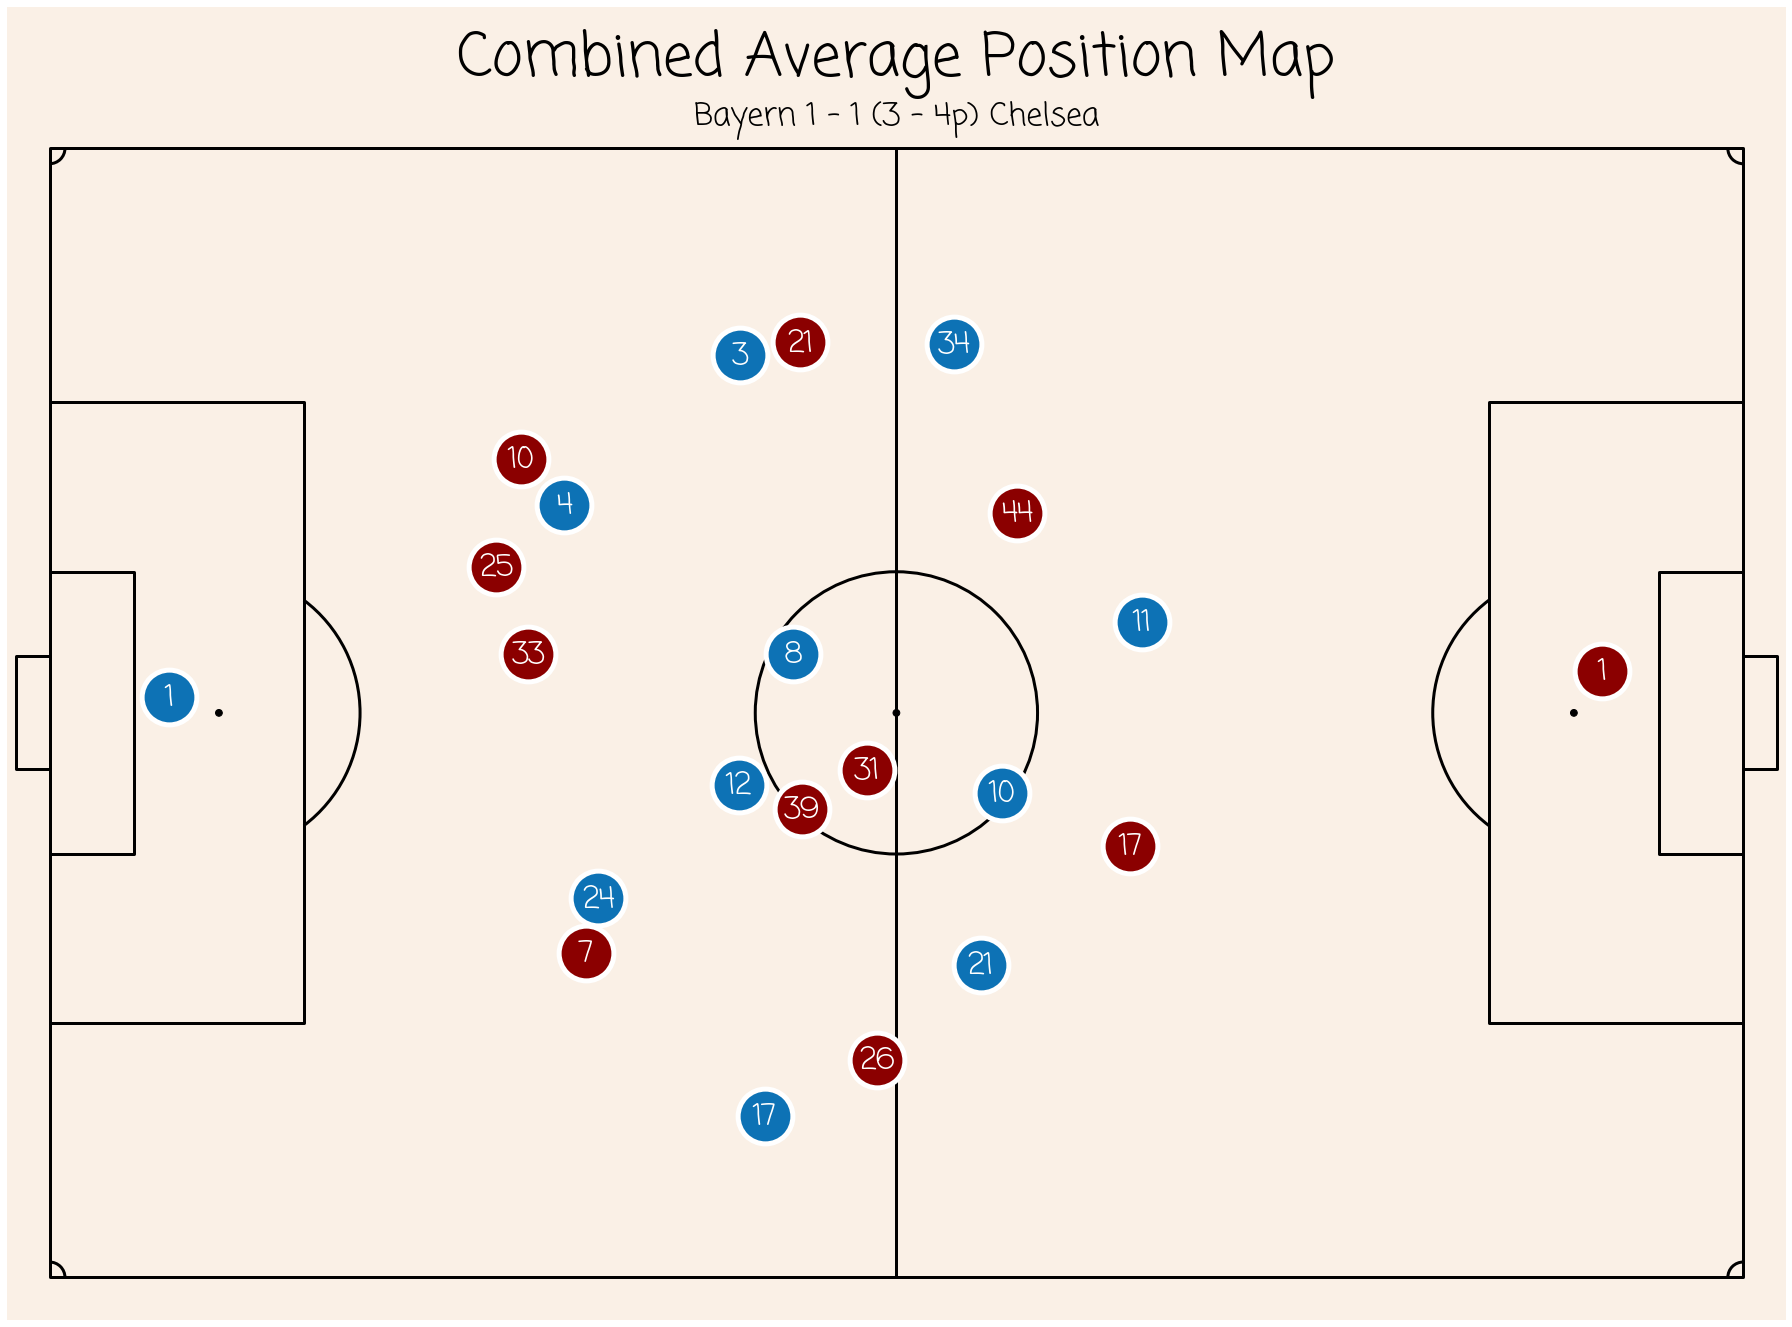

In [ ]:
# Define colours
pitch_colour = '#FAF0E6'
line_colour = 'black'
goal_colour = 'darkgreen'
shot_on_colour = 'green'
shot_off_colour = 'darkred'
shot_block_colour = 'grey'
text_colour = 'black'

node_size = 3000
bayern_munich_node_colour = 'darkred'
chelsea_node_colour = '#0D72B5'
edge_colour= 'white'


# Draw the pitch
pitch = Pitch(corner_arcs=True, goal_type='box',
                      pad_bottom=3, pad_top=10, pad_left=3, pad_right=3,
                      pitch_color=pitch_colour, line_color=line_colour, linewidth=3)
fig, ax = pitch.draw(figsize=(25, 25))


# Add title text
pitch.annotate('Combined Average Position Map', xy=(60, -6), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_title)
pitch.annotate('Bayern 1 - 1 (3 - 4p) Chelsea', xy=(60, -2), c=text_colour, va='center', ha='center', weight='bold', ax=ax,fontproperties = font_score)

for index, row in combined_started.iterrows():

  if str(row["player_name"]) == 'Petr Čech':
    display_name = 'Petr Cech'
  if str(row["player_nickname"]) == 'None':
    display_name = row['player_name']
  else:
    display_name = row['player_nickname']

  shirt_number = row['jersey_number']
  player_name = row['player_name']
  player_df = events_df.loc[events_df['player'] == player_name]

  average_x = []
  average_y = []

  for index, row in player_df.iterrows():

    team = row['team']

    if str(row['location_x']) != 'nan':
      if str(row['location_y']) != 'nan':

        if team == 'Chelsea':
          node_colour = chelsea_node_colour

          average_x.append(row['location_x'])
          average_y.append(row['location_y'])

        else:
          node_colour = bayern_munich_node_colour

          average_x.append(120 - row['location_x'])
          average_y.append(80 - row['location_y'])

  average_x = sum(average_x) / len(average_x)
  average_y = sum(average_y) / len(average_y)

  player_node = pitch.scatter(average_x, average_y, s=node_size, color=node_colour, edgecolors=edge_colour, linewidth=5, alpha=1, ax=ax)
  # pitch.annotate(display_name, xy=(average_x, average_y + 3.5), c=text_colour, va='center', ha='center', ax=ax, font_properties=font_name)
  pitch.annotate(shirt_number, xy=(average_x, average_y + 0.25), c='white', va='center', ha='center', ax=ax, font_properties=font_number)